<h1>SSD using Keras</h1>

This haven't included the multibox yet

In [1]:
import keras
import numpy as np
import os
from keras.utils import np_utils
from six.moves import cPickle as pickle
from matplotlib import pyplot as plt
from keras import models
from keras.layers import Dense, Convolution2D, Dropout, Activation, Flatten, MaxPool2D, Input, Conv2D, Add, BatchNormalization
from keras.layers import SeparableConv2D, DepthwiseConv2D, ReLU, AvgPool2D, GlobalAveragePooling2D

from keras.utils import plot_model
from keras.models import Model, Sequential
from keras import backend as K
import pydot

Using TensorFlow backend.


In [3]:
def read_pickled(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    f.close()
    return data

In [5]:
def initialize_data(dataset_dir):
    train_dataset_filename = os.path.join(dataset_dir, 'train_dataset', 'dataset.pickle')
    valid_dataset_filename = os.path.join(dataset_dir, 'valid_dataset', 'dataset.pickle')
    test_dataset_filename = os.path.join(dataset_dir, 'test_dataset', 'dataset.pickle')

    train_labels_filename = os.path.join(dataset_dir, 'train_dataset', 'labels.pickle')
    valid_labels_filename = os.path.join(dataset_dir, 'valid_dataset', 'labels.pickle')
    test_labels_filename = os.path.join(dataset_dir, 'test_dataset', 'labels.pickle')

    train_dataset = read_pickled(train_dataset_filename)
    valid_dataset = read_pickled(valid_dataset_filename)
    test_dataset = read_pickled(test_dataset_filename)

    train_labels = read_pickled(train_labels_filename)
    valid_labels = read_pickled(valid_labels_filename)
    test_labels = read_pickled(test_labels_filename)

    return train_dataset, valid_dataset, test_dataset, train_labels, valid_labels, test_labels

<h2>Read Dataset and Labels</h2>

In [131]:
image_height = 500
image_width = 500
num_class = [1, 1, 1, 1, 1]
num_channels = 1

root = '.'
dataset_dir = os.path.join(root, 'generated', 'ssd_samples_3')
train_dataset, valid_dataset, test_dataset, train_labels, valid_labels, test_labels = initialize_data(dataset_dir)

<h2>Data Checking</h2>

array([  1. , 381.5, 388. ,  75. , 150. ])

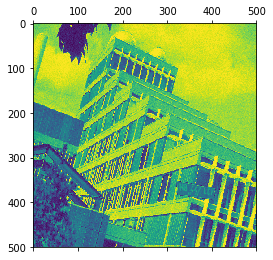

In [205]:
ix = np.random.choice(train_dataset.shape[0])
plt.matshow(train_dataset[ix])
train_labels[ix]

<h2>Reformat Dataset<h2>

Class label is not a classifier, so remove the categorical transform of the labels

In [5]:
train_dataset = train_dataset.reshape(1400, image_height, image_width, 1).astype(np.float32)
valid_dataset = valid_dataset.reshape(140, image_height, image_width, 1).astype(np.float32)
test_dataset = test_dataset.reshape(140, image_height, image_width, 1).astype(np.float32)

# Num digit
train_labels_0 = np_utils.to_categorical(train_labels[:, 0]-1, 4)
valid_labels_0 = np_utils.to_categorical(valid_labels[:, 0]-1, 4)
test_labels_0 = np_utils.to_categorical(test_labels[:, 0]-1, 4)

# Digit 1
train_labels_1 = np_utils.to_categorical(train_labels[:, 1], 11)
valid_labels_1 = np_utils.to_categorical(valid_labels[:, 1], 11)
test_labels_1 = np_utils.to_categorical(test_labels[:, 1], 11)

# Digit 2
train_labels_2 = np_utils.to_categorical(train_labels[:, 2], 11)
valid_labels_2 = np_utils.to_categorical(valid_labels[:, 2], 11)
test_labels_2 = np_utils.to_categorical(test_labels[:, 2], 11)

# Digit 3
train_labels_3 = np_utils.to_categorical(train_labels[:, 3], 11)
valid_labels_3 = np_utils.to_categorical(valid_labels[:, 3], 11)
test_labels_3 = np_utils.to_categorical(test_labels[:, 3], 11)

# Digit 4
train_labels_4 = np_utils.to_categorical(train_labels[:, 4], 11)
valid_labels_4 = np_utils.to_categorical(valid_labels[:, 4], 11)
test_labels_4 = np_utils.to_categorical(test_labels[:, 4], 11)

In [6]:
print("Reformed Train dataset : %s" % str(train_dataset.shape))
print("Reformed Valid dataset: %s" % str(valid_dataset.shape))
print("Reformed Test dataset: %s" % str(test_dataset.shape))

print("Reformed Train label 0: %s" % str(train_labels_0.shape))
print("Reformed Valid label 0: %s" % str(valid_labels_0.shape))
print("Reformed Test label 0: %s" % str(test_labels_0.shape))

print("Reformed Train label 1: %s" % str(train_labels_1.shape))
print("Reformed Valid label 1: %s" % str(valid_labels_1.shape))
print("Reformed Test label 1: %s" % str(test_labels_1.shape))

print("Reformed Train label 2: %s" % str(train_labels_2.shape))
print("Reformed Valid label 2: %s" % str(valid_labels_2.shape))
print("Reformed Test label 2: %s" % str(test_labels_2.shape))

print("Reformed Train label 3: %s" % str(train_labels_3.shape))
print("Reformed Valid label 3: %s" % str(valid_labels_3.shape))
print("Reformed Test label 3: %s" % str(test_labels_3.shape))

print("Reformed Train label 4: %s" % str(train_labels_4.shape))
print("Reformed Valid label 4: %s" % str(valid_labels_4.shape))
print("Reformed Test label 4: %s" % str(test_labels_4.shape))

Reformed Train dataset : (1400, 100, 200, 1)
Reformed Valid dataset: (140, 100, 200, 1)
Reformed Test dataset: (140, 100, 200, 1)
Reformed Train label 0: (1400, 4)
Reformed Valid label 0: (140, 4)
Reformed Test label 0: (140, 4)
Reformed Train label 1: (1400, 11)
Reformed Valid label 1: (140, 11)
Reformed Test label 1: (140, 11)
Reformed Train label 2: (1400, 11)
Reformed Valid label 2: (140, 11)
Reformed Test label 2: (140, 11)
Reformed Train label 3: (1400, 11)
Reformed Valid label 3: (140, 11)
Reformed Test label 3: (140, 11)
Reformed Train label 4: (1400, 11)
Reformed Valid label 4: (140, 11)
Reformed Test label 4: (140, 11)


<h2>Sanity Checking</h2>

In [7]:
def data_testing(dataset, labels, index):
    data = dataset[index].reshape(image_height, image_width)
    label = labels[index]
    print(label)
    print(data.shape)
    plt.matshow(data)
    plt.show()

[0. 0. 0. 1.]
(100, 200)


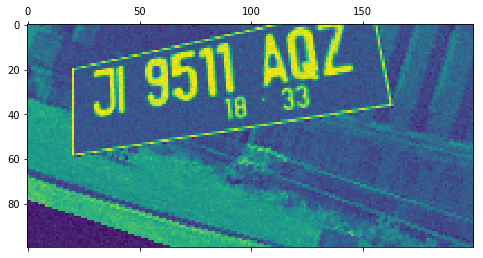

In [9]:
data_testing(train_dataset, train_labels_0, 344)

<h2>Implement xception module for mobilenetv2</h2>

In [10]:
def create_xception_block(input_layer, name, conv_mult, out_mult=0, depthwise_stride=1):
    """
    Create Xception Block for Mobilenet.v2
    :param input_layer: input layer 
    :param name: template name of the block
    :param conv_mult: multiplier for expand
    :param out_mult: 
    :return: output layer after processed from xception block
    """
    # Get the 4 th dimension
    d1 = input_layer.get_shape().as_list()[3]
    d2 = d1 * conv_mult
    
    expand1 = Conv2D(name=name + '_expand_input', filters=d2, kernel_size=(3, 3), padding='same')(input_layer)
    bn1 = BatchNormalization(name=name + '_bn1_expand', axis=1)(expand1)
    relu1 = ReLU(name=name + '_relu_bn1')(bn1)
    depthwise = DepthwiseConv2D(name=name + '_depthwise_relu', kernel_size=(3, 3), strides=depthwise_stride, padding='same')(relu1)
    bn2 = BatchNormalization(name=name + '_bn2_depthwise', axis=1)(depthwise)
    relu2 = ReLU(name=name + '_relu2_bn2')(bn2)
    
    if out_mult:
        shallow1 = Conv2D(name=name + '_shallow_relu2', filters=int(d1*out_mult), kernel_size=(3, 3), padding='same')(relu2)
        batch3 = BatchNormalization(name=name + '_bn3_shallow', axis=1)(shallow1)
        return batch3
    else:
        shallow1 = Conv2D(name=name + '_shallow_relu2', filters=d1, kernel_size=(3, 3), padding='same')(relu2)
        batch3 = BatchNormalization(name=name + '_bn3_shallow', axis=1)(shallow1)
        add = Add(name=name + '_add_bn3')([batch3, input_layer])
        return add

In [11]:
mobilenet_input = Input(shape=(100, 200, 1), name='input')
conv1_1 = Convolution2D(filters=32, kernel_size=(3, 3), strides=2, padding='same')(mobilenet_input)
bn_conv_1 = BatchNormalization(axis=1)(conv1_1)
relu_conv_1 = Activation(activation='relu')(bn_conv_1)
expanded_depthwise_1 = DepthwiseConv2D(kernel_size=(3, 3), padding='same')(relu_conv_1)
bn_depthwise_1 = BatchNormalization(axis=1)(expanded_depthwise_1)
relu_depthwise_1 = Activation(activation='relu')(bn_depthwise_1)
conv2_1 = Convolution2D(filters=16, kernel_size=(3, 3), strides=1, padding='same')(relu_depthwise_1)
bn_conv2_1 = BatchNormalization(axis=1)(conv2_1)

block_1_out = create_xception_block(bn_conv2_1, name='block1', conv_mult=6)
block_2_out = create_xception_block(block_1_out, name='block_2', conv_mult=2)
block_3_out = create_xception_block(block_2_out, name='block_3', conv_mult=6, out_mult=1.5, depthwise_stride=2)

digits_out_layer = Conv2D(1024, kernel_size=(3, 3), strides=1, padding='same')(block_3_out)
digits_out_layer_bn = BatchNormalization(axis=1)(digits_out_layer)
digits_out_layer_flatten = GlobalAveragePooling2D()(digits_out_layer_bn)
digits_out_layer_softmax = Dense(4, activation='softmax', name='logits0')(digits_out_layer_flatten)

block_4_out = create_xception_block(block_3_out, name='block_4', conv_mult=6)
block_5_out = create_xception_block(block_4_out, name='block_5', conv_mult=2)
block_6_out = create_xception_block(block_5_out, name='block_6', conv_mult=2, out_mult=2, depthwise_stride=2)

digit1_out_layer = Conv2D(1024, kernel_size=(3, 3), strides=1, padding='same')(block_6_out)
digit1_out_layer_bn = BatchNormalization(axis=1)(digit1_out_layer)
digit1_out_layer_flatten = GlobalAveragePooling2D()(digit1_out_layer_bn)
digit1_out_layer_softmax = Dense(11, activation='softmax', name='logits1')(digit1_out_layer_flatten)

digit2_out_layer = Conv2D(1024, kernel_size=(3, 3), strides=1, padding='same')(block_6_out)
digit2_out_layer_bn = BatchNormalization(axis=1)(digit2_out_layer)
digit2_out_layer_flatten = GlobalAveragePooling2D()(digit2_out_layer_bn)
digit2_out_layer_softmax = Dense(11, activation='softmax', name='logits2')(digit2_out_layer_flatten)

digit3_out_layer = Conv2D(1024, kernel_size=(3, 3), strides=1, padding='same')(block_6_out)
digit3_out_layer_bn = BatchNormalization(axis=1)(digit3_out_layer)
digit3_out_layer_flatten = GlobalAveragePooling2D()(digit3_out_layer_bn)
digit3_out_layer_softmax = Dense(11, activation='softmax', name='logits3')(digit3_out_layer_flatten)

digit4_out_layer = Conv2D(1024, kernel_size=(3, 3), strides=1, padding='same')(block_6_out)
digit4_out_layer_bn = BatchNormalization(axis=1)(digit4_out_layer)
digit4_out_layer_flatten = GlobalAveragePooling2D()(digit4_out_layer_bn)
digit4_out_layer_softmax = Dense(11, activation='softmax', name='logits4')(digit4_out_layer_flatten)

In [12]:
outputs0 = [digits_out_layer_softmax, 
            digit1_out_layer_softmax, 
            digit2_out_layer_softmax, 
            digit3_out_layer_softmax, 
            digit4_out_layer_softmax]
out_model = Model(inputs=mobilenet_input, outputs=outputs0)
plot_model(out_model, show_shapes=True)
# print(out_model.summary())
# print(bn_conv2_1.get_shape().as_list()[3])

In [14]:
batch_size = 8
loss = {'logits0': 'categorical_crossentropy',
        'logits1': 'categorical_crossentropy',
        'logits2': 'categorical_crossentropy',
        'logits3': 'categorical_crossentropy',
        'logits4': 'categorical_crossentropy'}
metrics = {'logits0': 'accuracy',
           'logits1': 'accuracy',
           'logits2': 'accuracy',
           'logits3': 'accuracy',
           'logits4': 'accuracy'}
loss_weights = {'logits0': 1.0, 
                'logits1': 1.0, 
                'logits2': 1.0, 
                'logits3': 1.0, 
                'logits4': 1.0, }
y = [train_labels_0, 
     train_labels_1, 
     train_labels_2, 
     train_labels_3, 
     train_labels_4]
valid_y = [valid_labels_0, 
           valid_labels_1, 
           valid_labels_2, 
           valid_labels_3, 
           valid_labels_4]
test_y = [test_labels_0, 
          test_labels_1, 
          test_labels_2, 
          test_labels_3, 
          test_labels_4]
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=os.path.join(dataset_dir, 'tensorboard'), batch_size=batch_size, 
                                            histogram_freq=1, write_graph=True,  write_grads=True)
out_model.compile(loss=loss,
                  optimizer=keras.optimizers.adadelta(lr=.01),
                  metrics=metrics,
                  loss_weights=loss_weights)
out_model.fit(x=train_dataset, y=y,
              batch_size=batch_size, epochs=10, verbose=1,
              validation_data=(valid_dataset, valid_y),
              callbacks=[tensorboard_cb], )
score = out_model.evaluate(test_dataset, test_y, verbose=1)
print('Test loss: ', score[0])
print('Test accuracy', score[1])
